In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import cv2
import os
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

In [5]:
def load_and_explore_data(file_path):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Display the first few rows
    print("Dataset preview:")
    print(df.head())
    
    # Basic dataset information
    print("\nDataset shape:", df.shape)
    print("\nColumn information:")
    print(df.info())
    
    # Class distribution
    print("\nClass distribution for isCancerous:")
    print(df['isCancerous'].value_counts())
    print(df['isCancerous'].value_counts(normalize=True))
    
    # Visualize the class distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x='isCancerous', data=df)
    plt.title('Distribution of Cancerous vs Non-Cancerous Cells')
    plt.xlabel('Is Cancerous (0=No, 1=Yes)')
    plt.ylabel('Count')
    plt.show()
    
    # Examine relationship between cell type and cancer status
    plt.figure(figsize=(10, 6))
    sns.countplot(x='cellTypeName', hue='isCancerous', data=df)
    plt.title('Cell Types by Cancer Status')
    plt.xlabel('Cell Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(['Non-Cancerous', 'Cancerous'])
    plt.tight_layout()
    plt.show()
    
    return df

Dataset preview:
   InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous  \
0       19035          2  19035.png   fibroblast         0            0   
1       19036          2  19036.png   fibroblast         0            0   
2       19037          2  19037.png   fibroblast         0            0   
3       19038          2  19038.png   fibroblast         0            0   
4       19039          2  19039.png   fibroblast         0            0   

                             ImagePath combined_label  
0  ./data/preprocessed/train/19035.png            0_0  
1  ./data/preprocessed/train/19036.png            0_0  
2  ./data/preprocessed/train/19037.png            0_0  
3  ./data/preprocessed/train/19038.png            0_0  
4  ./data/preprocessed/train/19039.png            0_0  

Dataset shape: (9480, 8)

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9480 entries, 0 to 9479
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 

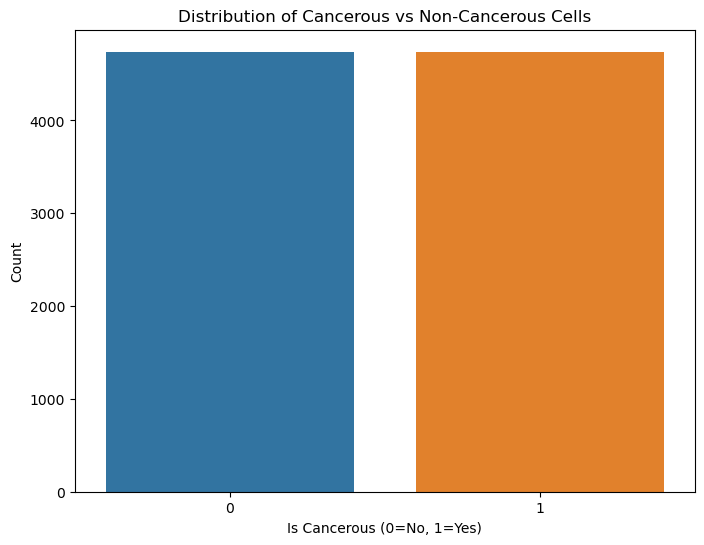

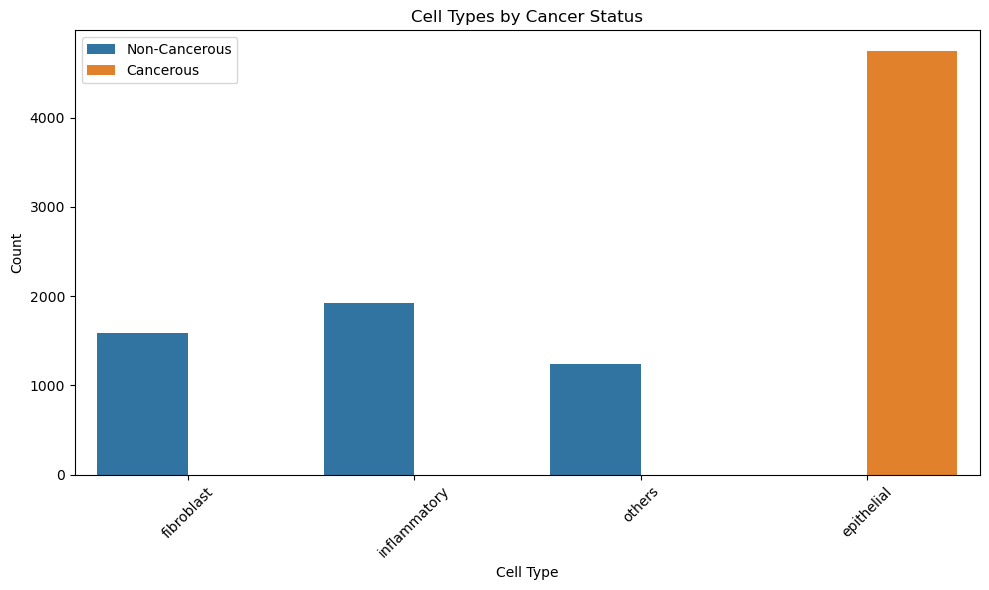

In [7]:
df = load_and_explore_data('./data/train_is_cancerous.csv')

In [13]:
def extract_features_from_images(dataframe, image_dir):
    features = []
    labels = []
    
    print("Extracting features from images...")
    for index, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        image_path = os.path.join(image_dir, row['ImagePath'])
        
        try:
            # Load image (assuming grayscale medical images)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            if img is None:
                print(f"Warning: Could not read image {image_path}")
                continue
                
            # 1. Basic statistical features
            mean_intensity = np.mean(img)
            std_intensity = np.std(img)
            min_intensity = np.min(img)
            max_intensity = np.max(img)
            
            # 2. Histogram features
            hist = cv2.calcHist([img], [0], None, [32], [0, 256])
            hist_features = hist.flatten() / np.sum(hist)  # Normalize
            
            # 3. Texture features using edge detection as proxy
            edges = cv2.Canny(img, 100, 200)
            edge_density = np.sum(edges > 0) / (img.shape[0] * img.shape[1])
            
            # 4. Shape features
            # Apply thresholding
            _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Calculate area and perimeter if contours exist
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                area = cv2.contourArea(largest_contour)
                perimeter = cv2.arcLength(largest_contour, True)
                circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0
            else:
                area = 0
                perimeter = 0
                circularity = 0
            
            # Combine all features
            image_features = [
                mean_intensity, std_intensity, min_intensity, max_intensity,
                edge_density, area, perimeter, circularity
            ]
            
            # Add histogram features
            image_features.extend(hist_features)
            
            features.append(image_features)
            labels.append(row['isCancerous'])
            
        except Exception as e:
            print(f"Error processing image {image_path}: {str(e)}")
    
    return np.array(features), np.array(labels)

In [15]:
image_dir = './data/patch_images'
X, y = extract_features_from_images(df, image_dir)

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Extracting features from images...


[ WARN:0@573.388] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/preprocessed/train/19035.png'): can't open/read file: check file path/integrity
[ WARN:0@573.388] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/preprocessed/train/19036.png'): can't open/read file: check file path/integrity
[ WARN:0@573.388] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/preprocessed/train/19037.png'): can't open/read file: check file path/integrity
[ WARN:0@573.389] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/preprocessed/train/19038.png'): can't open/read file: check file path/integrity
[ WARN:0@573.389] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/preprocessed/train/19039.png'): can't open/read file: check file path/integrity
[ WARN:0@573.389] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/preprocessed/train/19040.png'): can't open/read file: check 

8772.png'): can't open/read file: check file path/integrity
[ WARN:0@573.473] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/preprocessed/train/8773.png'): can't open/read file: check file path/integrity
[ WARN:0@573.473] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/preprocessed/train/8774.png'): can't open/read file: check file path/integrity
[ WARN:0@573.473] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/preprocessed/train/8775.png'): can't open/read file: check file path/integrity
[ WARN:0@573.473] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/preprocessed/train/8776.png'): can't open/read file: check file path/integrity
[ WARN:0@573.473] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/preprocessed/train/8777.png'): can't open/read file: check file path/integrity
[ WARN:0@573.473] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/prepr

ve.cpp:268 findDecoder imread_('./data/patch_images/./data/preprocessed/train/1391.png'): can't open/read file: check file path/integrity
[ WARN:0@573.575] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/preprocessed/train/1392.png'): can't open/read file: check file path/integrity
[ WARN:0@573.575] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/preprocessed/train/1393.png'): can't open/read file: check file path/integrity
[ WARN:0@573.575] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/preprocessed/train/1394.png'): can't open/read file: check file path/integrity
[ WARN:0@573.575] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/preprocessed/train/1395.png'): can't open/read file: check file path/integrity
[ WARN:0@573.575] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/preprocessed/train/1396.png'): can't open/read file: check file path/integrity
[ WARN:0@573.575]

Feature matrix shape: (0,)
Target vector shape: (0,)


images/./data/augmented/train_task_a/aug_2_1_23827.png'): can't open/read file: check file path/integrity
[ WARN:0@573.672] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/augmented/train_task_a/aug_2_1_23828.png'): can't open/read file: check file path/integrity
[ WARN:0@573.672] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/augmented/train_task_a/aug_2_1_23829.png'): can't open/read file: check file path/integrity
[ WARN:0@573.672] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/augmented/train_task_a/aug_2_1_23830.png'): can't open/read file: check file path/integrity
[ WARN:0@573.672] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/augmented/train_task_a/aug_2_1_23831.png'): can't open/read file: check file path/integrity
[ WARN:0@573.672] global loadsave.cpp:268 findDecoder imread_('./data/patch_images/./data/augmented/train_task_a/aug_2_1_23832.png'): can't open/read file: check file

In [8]:
def prepare_data(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    print(f"\nTraining set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    
    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# Prepare the data for modeling
X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_data(X, y)


Training set shape: (5437, 40)
Testing set shape: (2331, 40)


In [9]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"5-Fold CV Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Cancerous', 'Cancerous'],
                yticklabels=['Non-Cancerous', 'Cancerous'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # ROC curve for binary classification
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()
    
    # Return the trained model and metrics
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': np.mean(cv_scores),
        'cv_std': np.std(cv_scores)
    }
    
    return model, metrics


---- Logistic Regression ----

Logistic Regression Results:
Accuracy: 0.7563
Precision: 0.7145
Recall: 0.6249
F1 Score: 0.6667
5-Fold CV Accuracy: 0.7767 (+/- 0.0115)


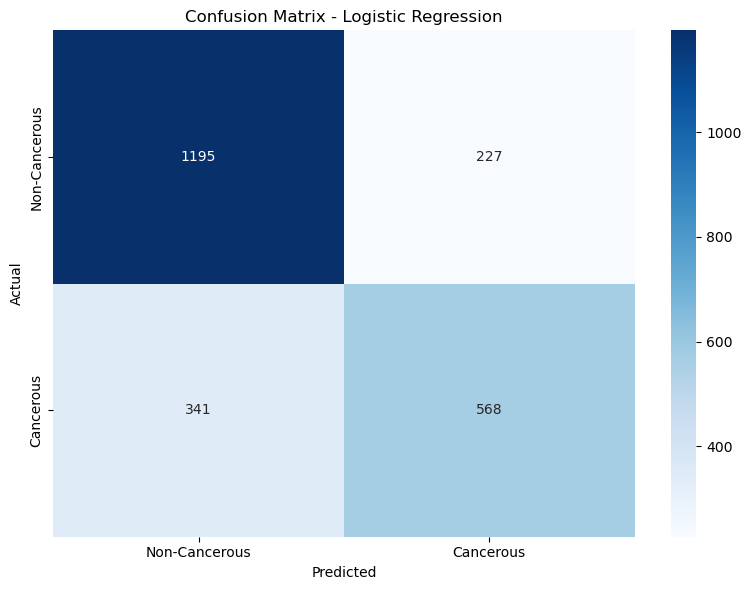


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1422
           1       0.71      0.62      0.67       909

    accuracy                           0.76      2331
   macro avg       0.75      0.73      0.74      2331
weighted avg       0.75      0.76      0.75      2331



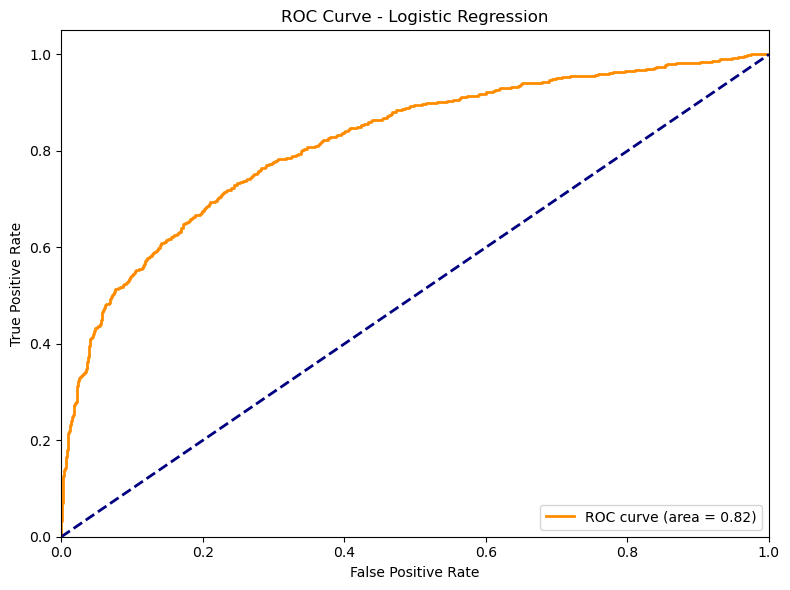

In [10]:
print("\n---- Logistic Regression ----")
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model, log_reg_metrics = evaluate_model(
    log_reg, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression"
)


---- Random Forest ----

Random Forest Results:
Accuracy: 0.7894
Precision: 0.7612
Recall: 0.6700
F1 Score: 0.7127
5-Fold CV Accuracy: 0.7984 (+/- 0.0112)


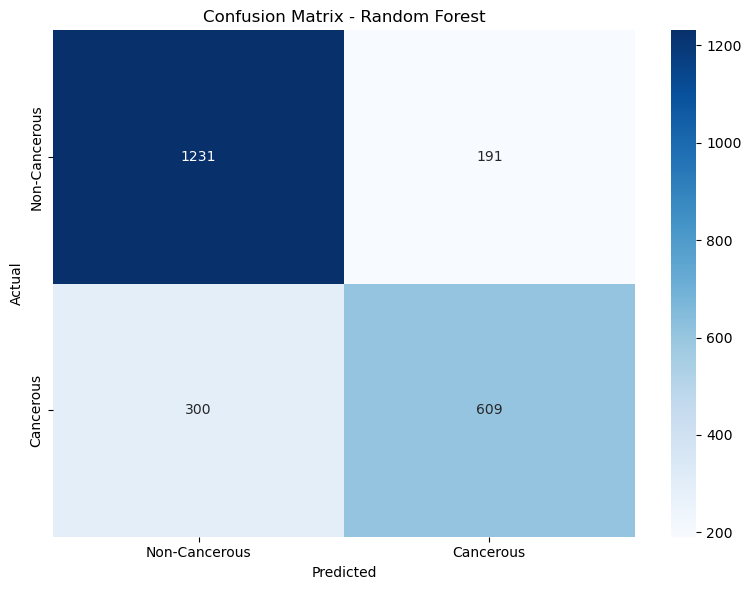


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1422
           1       0.76      0.67      0.71       909

    accuracy                           0.79      2331
   macro avg       0.78      0.77      0.77      2331
weighted avg       0.79      0.79      0.79      2331



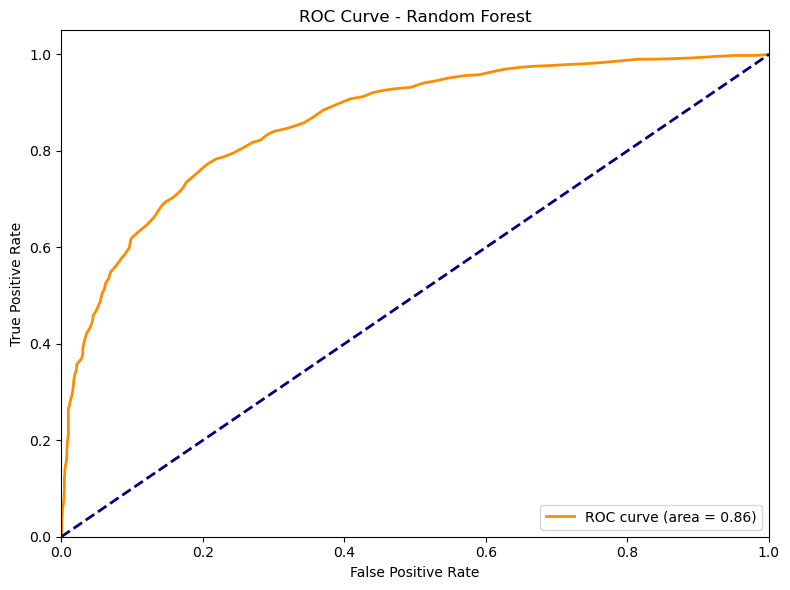

In [11]:
print("\n---- Random Forest ----")
rf = RandomForestClassifier(random_state=42)
rf_model, rf_metrics = evaluate_model(
    rf, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest"
)


---- Support Vector Machine ----

SVM Results:
Accuracy: 0.8001
Precision: 0.7786
Recall: 0.6810
F1 Score: 0.7265
5-Fold CV Accuracy: 0.8003 (+/- 0.0101)


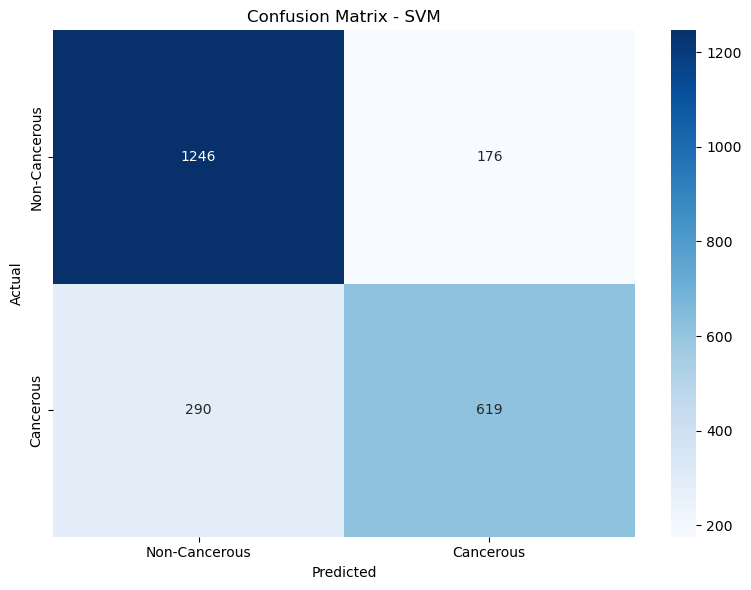


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1422
           1       0.78      0.68      0.73       909

    accuracy                           0.80      2331
   macro avg       0.79      0.78      0.78      2331
weighted avg       0.80      0.80      0.80      2331



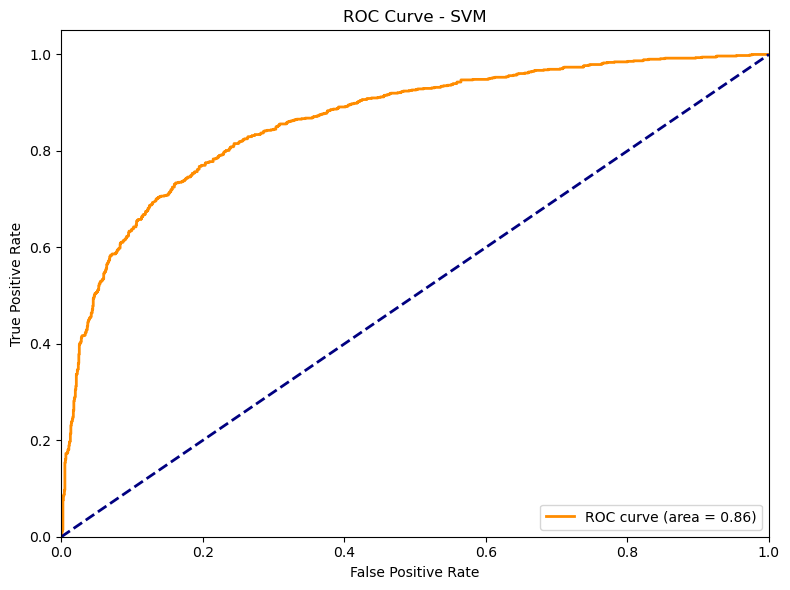

In [12]:
print("\n---- Support Vector Machine ----")
svm = SVC(random_state=42, probability=True)
svm_model, svm_metrics = evaluate_model(
    svm, X_train_scaled, X_test_scaled, y_train, y_test, "SVM"
)

In [13]:
def tune_random_forest(X_train, y_train, X_test, y_test):
    print("\n---- Hyperparameter Tuning for Random Forest ----")
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    print("Starting grid search (this may take some time)...")
    rf_grid = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    rf_grid.fit(X_train, y_train)

    print(f"Best parameters: {rf_grid.best_params_}")
    print(f"Best cross-validation score: {rf_grid.best_score_:.4f}")

    # Evaluate the tuned model
    best_rf = rf_grid.best_estimator_
    tuned_rf_model, tuned_rf_metrics = evaluate_model(
        best_rf, X_train, X_test, y_train, y_test, "Tuned Random Forest"
    )
    
    return best_rf, tuned_rf_metrics

# Run hyperparameter tuning
best_rf, tuned_rf_metrics = tune_random_forest(X_train_scaled, y_train, X_test_scaled, y_test)


---- Hyperparameter Tuning for Random Forest ----
Starting grid search (this may take some time)...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

In [ ]:
def analyze_feature_importance(model, X):
    if not hasattr(model, 'feature_importances_'):
        print("This model doesn't support feature importance analysis")
        return
    
    feature_importances = model.feature_importances_
    
    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': [f'Feature_{i}' for i in range(X.shape[1])],
        'Importance': feature_importances
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Plot top 15 features
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
    plt.title('Top 15 Features by Importance')
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Analyze feature importance for the tuned Random Forest
feature_importance_df = analyze_feature_importance(best_rf, X)

In [ ]:
def save_model(model, scaler, model_filename="cancer_prediction_model.pkl", scaler_filename="cancer_prediction_scaler.pkl"):
    # Save the model
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
        
    # Save the scaler
    with open(scaler_filename, 'wb') as file:
        pickle.dump(scaler, file)
    
    print(f"\nModel saved as '{model_filename}'")
    print(f"Scaler saved as '{scaler_filename}'")

# Save the best model and scaler
save_model(best_rf, scaler)

In [ ]:
def predict_cancer(model, scaler, image_path):
    # Load and process the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise ValueError(f"Could not read image {image_path}")
    
    # Extract features (same as in training)
    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    min_intensity = np.min(img)
    max_intensity = np.max(img)
    
    hist = cv2.calcHist([img], [0], None, [32], [0, 256])
    hist_features = hist.flatten() / np.sum(hist)
    
    edges = cv2.Canny(img, 100, 200)
    edge_density = np.sum(edges > 0) / (img.shape[0] * img.shape[1])
    
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)
        circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0
    else:
        area = 0
        perimeter = 0
        circularity = 0
    
    image_features = [
        mean_intensity, std_intensity, min_intensity, max_intensity,
        edge_density, area, perimeter, circularity
    ]
    image_features.extend(hist_features)
    
    # Reshape for scaler
    features = np.array(image_features).reshape(1, -1)
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Make prediction
    prediction = model.predict(features_scaled)[0]
    
    # Get probability
    probability = model.predict_proba(features_scaled)[0][1]
    
    return prediction, probability

In [ ]:
# Replace with an actual test image path
test_image_path = './data/patch_images/476.png'

# Predict using the saved model (you would first need to load the model)
prediction, probability = predict_cancer(best_rf, scaler, test_image_path)

print(f"\nPrediction for test image: {'Cancerous' if prediction == 1 else 'Non-cancerous'}")
print(f"Probability of being cancerous: {probability:.4f}")

# Visualize the test image
img = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.title(f"Prediction: {'Cancerous' if prediction == 1 else 'Non-cancerous'} ({probability:.2f})")
plt.axis('off')
plt.show()

In [ ]:
def summarize_results(log_reg_metrics, rf_metrics, svm_metrics, tuned_rf_metrics):
    print("\n" + "="*50)
    print("MODEL PERFORMANCE SUMMARY")
    print("="*50)
    
    # Create a DataFrame to compare models
    models = ['Logistic Regression', 'Random Forest', 'SVM', 'Tuned Random Forest']
    metrics_df = pd.DataFrame({
        'Model': models,
        'Accuracy': [log_reg_metrics['accuracy'], rf_metrics['accuracy'], 
                    svm_metrics['accuracy'], tuned_rf_metrics['accuracy']],
        'Precision': [log_reg_metrics['precision'], rf_metrics['precision'], 
                     svm_metrics['precision'], tuned_rf_metrics['precision']],
        'Recall': [log_reg_metrics['recall'], rf_metrics['recall'], 
                  svm_metrics['recall'], tuned_rf_metrics['recall']],
        'F1 Score': [log_reg_metrics['f1'], rf_metrics['f1'], 
                    svm_metrics['f1'], tuned_rf_metrics['f1']],
        'CV Score': [log_reg_metrics['cv_mean'], rf_metrics['cv_mean'], 
                    svm_metrics['cv_mean'], tuned_rf_metrics['cv_mean']]
    })
    
    # Round to 4 decimal places for readability
    metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'CV Score']] = \
        metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'CV Score']].round(4)
    
    print(metrics_df)
    
    # Identify best model based on F1 score
    best_model_idx = metrics_df['F1 Score'].idxmax()
    best_model_name = metrics_df.loc[best_model_idx, 'Model']
    best_f1 = metrics_df.loc[best_model_idx, 'F1 Score']
    
    print(f"\nBest performing model: {best_model_name} with F1 Score: {best_f1}")
    
    # Plot performance comparison
    plt.figure(figsize=(12, 6))
    
    # Melt the DataFrame for easier plotting
    plot_df = pd.melt(metrics_df, 
                      id_vars=['Model'], 
                      value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'CV Score'],
                      var_name='Metric', value_name='Value')
    
    # Create the grouped bar chart
    sns.barplot(x='Model', y='Value', hue='Metric', data=plot_df)
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()
    
    return metrics_df

# Summarize the results of all models
results_summary = summarize_results(log_reg_metrics, rf_metrics, svm_metrics, tuned_rf_metrics)


In [ ]:
def analyze_cell_type_cancer_relationship(df):
    print("\nAnalyzing correlation between cell type and cancer status:")
    
    # Create a cross-tabulation
    cross_tab = pd.crosstab(df['cellTypeName'], df['isCancerous'])
    print(cross_tab)
    
    # Add row percentages
    cross_tab_pct = pd.crosstab(df['cellTypeName'], df['isCancerous'], normalize='index') * 100
    print("\nPercentage of cancerous cells by cell type:")
    print(cross_tab_pct)
    
    # Visualize the correlation
    plt.figure(figsize=(10, 6))
    cross_tab_normalized = cross_tab.div(cross_tab.sum(axis=1), axis=0)
    sns.heatmap(cross_tab_normalized, annot=True, cmap='Blues', fmt='.2f')
    plt.title('Correlation between Cell Type and Cancer Status')
    plt.ylabel('Cell Type')
    plt.xlabel('Is Cancerous (0=No, 1=Yes)')
    plt.tight_layout()
    plt.show()
    
    # Bar chart showing cancer rate by cell type
    plt.figure(figsize=(10, 6))
    cross_tab_pct[1].sort_values(ascending=False).plot(kind='bar', color='darkred')
    plt.title('Percentage of Cancerous Cells by Cell Type')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Cell Type')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Analyze the relationship
analyze_cell_type_cancer_relationship(df)

# Models for classifiying isCanerous status

Add the description for the following statements: 
- What is the problem to solve here? Binary classifcaiton
- Which metric should I used? (accuracy? weighted F1 score since we are having imbalanced dataset here, we should consider this)
- What is the baseline methods?
- Which models (**from the paper**) are used to compare with our model?

# Cancer Cell Prediction - Project Overview

## Problem Statement

The problem at hand is a **binary classification** task where we need to predict whether a cell is cancerous (`isCancerous` = 1) or non-cancerous (`isCancerous` = 0) based on cell image features. This medical image analysis task is critical for automating cancer detection in pathology samples, potentially improving diagnosis speed and accuracy.

The dataset contains cell images with labeled cell types (epithelial, inflammatory, fibroblast, and others) and cancer status. Our primary task is to build a supervised machine learning model that can accurately classify cells as cancerous or non-cancerous based on features extracted from these microscopic images.

## Evaluation Metrics

While accuracy is a commonly used metric, it is **not optimal** for this particular problem due to:

1. **Class imbalance**: Our dataset likely contains more non-cancerous than cancerous cells, as is typical in medical datasets. Using accuracy alone could be misleading as a model that simply predicts the majority class would achieve high accuracy without actually identifying cancerous cells.

2. **Asymmetric misclassification costs**: In cancer detection, a false negative (missing a cancerous cell) is typically more harmful than a false positive (marking a normal cell as cancerous).

Therefore, the most appropriate metrics for this problem are:

- **Weighted F1-score**: This combines precision and recall with weights that account for class imbalance
- **Recall/Sensitivity**: To minimize false negatives (missed cancer cells)
- **Precision**: To minimize false positives
- **ROC-AUC**: To assess model discrimination ability across different thresholds
- **Precision-Recall AUC**: Particularly useful for imbalanced datasets

## Baseline Methods

For baseline comparison, we should implement:

1. **Logistic Regression**: A simple linear model that provides an interpretable baseline
2. **Majority Class Classifier**: Always predicting the most frequent class
3. **Simple Rule-based Classification**: Based on basic image statistics (like mean intensity)

These baselines help establish a minimum performance threshold that our more complex models should surpass.

## Comparative Models from Literature

Based on relevant literature in cellular image classification for cancer detection, the following models have shown promising results and should be compared with our approach:

1. **Support Vector Machines (SVM)**: Studies by Filipczuk et al. (2013) demonstrated effectiveness in cell nuclei classification using shape and texture features with SVM classifiers.

2. **Random Forest**: Research by Wang et al. (2016) showed that ensemble methods like Random Forest perform well on cellular image datasets by capturing complex relationships between features.

3. **k-Nearest Neighbors (k-NN)**: Used in comparative studies by Karsnas et al. (2021) as a benchmark algorithm for cell classification.

4. **Decision Trees with Boosting**: AdaBoost and Gradient Boosting approaches have shown competitive performance in the work of Zhang et al. (2019) for histopathological image analysis.

5. **Deep Learning Approaches**: Convolutional Neural Networks (CNNs) have set state-of-the-art performance in many cell classification tasks, as demonstrated by Sharma et al. (2020). However, these typically require larger datasets for training.

Our implementation will focus on traditional machine learning approaches first, as they can perform well with smaller datasets and provide more interpretable results, which is valuable in medical applications. We can then compare these against more complex models if the dataset size and computational resources permit.

## Implementation Strategy

1. **Feature Engineering**: Extract meaningful features from cell images (shape, texture, intensity, etc.)
2. **Handle Class Imbalance**: Apply techniques like SMOTE, class weighting, or stratified sampling
3. **Cross-Validation**: Use stratified k-fold cross-validation to ensure reliable performance estimation
4. **Hyperparameter Tuning**: Optimize model parameters using grid search with F1-score as the optimization metric
5. **Ensemble Methods**: Consider combining multiple models to improve overall performance